
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [56]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sbn

In [120]:
DATASET = 'b2w'

#Dropout: 0, 10%
DROPOUT = 0.10

#Learning rate: 2.5e-5, 5e-5
LEARNING_RATE = 5e-5

FOLDS = 10

TRAIN_NUM = '04'

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [5]:
df = pd.read_csv(f'../datasets/{DATASET}_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [7]:
print(f'dataset preprocessado e balanceado: {DATASET} -> {df.shape[0]} instancias')

dataset preprocessado e balanceado: b2w -> 71516 instancias


In [8]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

#### Tentativa de treinamento com 10% do dataset

In [16]:
#bach_01_text_train, bach_01_text_test, bach_01_labels_train, bach_01_labels_test = train_test_split(df['review_text'], df['rating'], train_size=0.1, random_state=42)

In [17]:
#print(f'{bach_01_text_train.shape[0]} para treinamento')

In [9]:
df['rating'].value_counts()

rating
0    35758
1    35758
Name: count, dtype: int64

In [11]:
reviews = df['review_text']
labels = df['rating']

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [12]:
embeddings = []
for review in tqdm((reviews), desc="Processing"):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing: 100%|██████████| 71516/71516 [2:18:37<00:00,  8.60it/s]   


In [121]:
embeddings_array = np.vstack(embeddings)

In [122]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

71516 embeddings de 768 dimensões


#### Feature based 1

In [123]:
additional_features = np.array([[len(str(review).split())] for review in reviews])

In [124]:
print(embeddings_array.shape)
print(additional_features.shape)

(71516, 768)
(71516, 1)


#### Combinando embeddings_array e additional_features

In [125]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [126]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [127]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [128]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [129]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                18480     
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [131]:
#CHECKPOINT=ModelCheckpoint(filepath='./weights/b2w_tlm_peq_fb1_weights.hdf5', verbose=0, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]

#### Cross-validation

In [132]:
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

#### Treinamento do modelo

In [133]:
fold = 0

# -----------------------------------------------------------------------------

train_loss_history = []
train_accuracy_history = []

fold_train_losses = []
fold_train_accuracies = []
fold_train_f1_scores = []

train_tprs = []
train_aucs = []
train_mean_fpr = np.linspace(0, 1, 100)

# -----------------------------------------------------------------------------

fold_accuracies = []
fold_f1_scores = []

for train_indices, val_indices in tqdm((kf.split(combined_features)),desc="Processing"):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
        
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    # -----------------------------------------------------------------------------
    
    # train losses ecah fold
    fold_train_losses.append(model_history.history['val_loss'])
    
    # train accuracy each fold
    fold_train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 score each fold
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_pred_train)
    fold_train_f1_scores.append(f1_score(y_train_fold_tensor, y_pred_train_binary))
    
    # train roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train_fold_tensor, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_tprs.append(np.interp(train_mean_fpr, fpr, tpr))
    train_aucs.append(roc_auc)
    
    # -----------------------------------------------------------------------------
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print('Finished train!')

Processing: 0it [00:00, ?it/s]

fold = 1
224/224 [==============================] - 0s 947us/step


Processing: 1it [00:26, 26.05s/it]

fold = 2
224/224 [==============================] - 0s 751us/step


Processing: 2it [00:51, 25.74s/it]

fold = 3
224/224 [==============================] - 0s 774us/step


Processing: 3it [01:17, 25.64s/it]

fold = 4
224/224 [==============================] - 0s 775us/step


Processing: 4it [01:42, 25.53s/it]

fold = 5
224/224 [==============================] - 0s 756us/step


Processing: 5it [02:07, 25.52s/it]

fold = 6
224/224 [==============================] - 0s 771us/step


Processing: 6it [02:33, 25.47s/it]

fold = 7
224/224 [==============================] - 0s 824us/step


Processing: 7it [02:52, 23.34s/it]

fold = 8
224/224 [==============================] - 0s 839us/step


Processing: 8it [03:17, 24.02s/it]

fold = 9
224/224 [==============================] - 0s 970us/step


Processing: 9it [03:38, 23.07s/it]

fold = 10
224/224 [==============================] - 0s 785us/step


Processing: 10it [03:57, 23.75s/it]

Finished train!


In [134]:
train_accuracy_mean_value = round(np.mean([np.mean(train_ac) for train_ac in fold_train_accuracies]),4)
train_f1_mean_value = round(np.mean([np.mean(train_f1) for train_f1 in fold_train_f1_scores]),4)
print(f"Media Accuracy Treino: {train_accuracy_mean_value}")
print(f"Media f1 score Treino: {train_f1_mean_value}")
print('-'*80)
print("Media Accuracy Validacao:", np.mean(fold_accuracies))
print("Media f1 score Validacao", np.mean(fold_f1_scores))

Media Accuracy Treino: 0.9301
Media f1 score Treino: 0.9375
--------------------------------------------------------------------------------
Media Accuracy Validacao: 0.9376924958790827
Media f1 score Validacao 0.9367732218044988


In [135]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{metric}_train_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{metric}_train_loss_folds_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(train_mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{desc}_train_roc_auc_curve_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.savefig(f'./graphs/tlm_gran_fb2_mlp_val_confusion_matrix_test_{TRAIN_NUM}.png')
    plt.show()

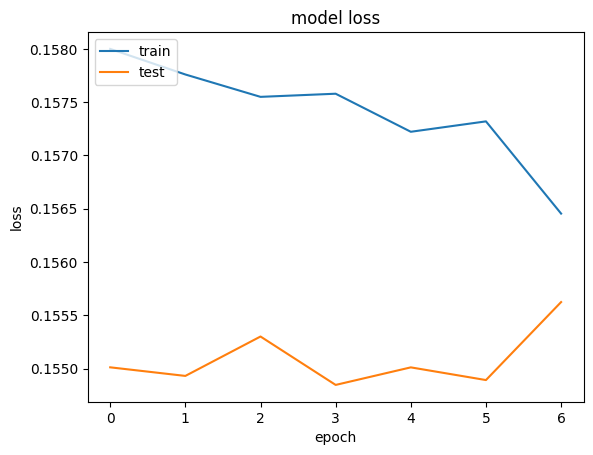

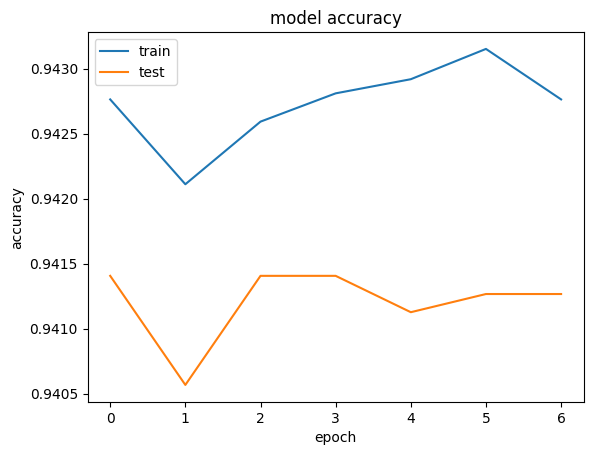

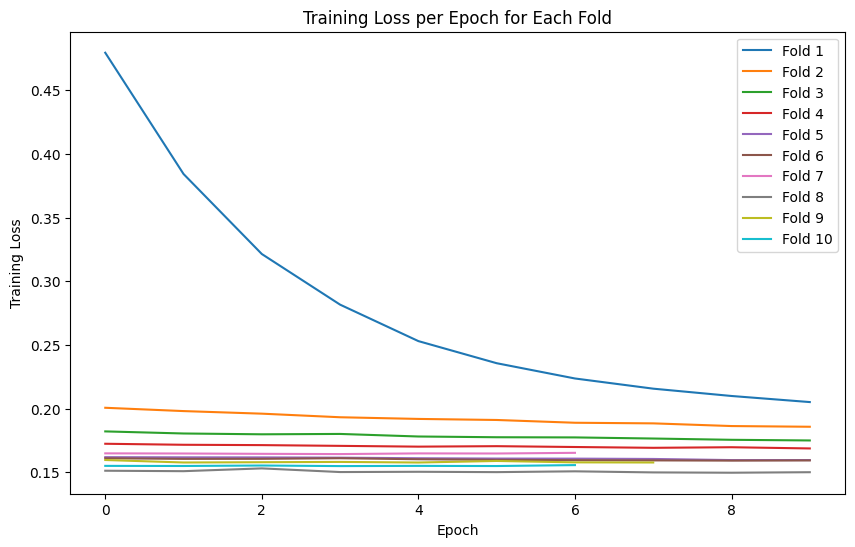

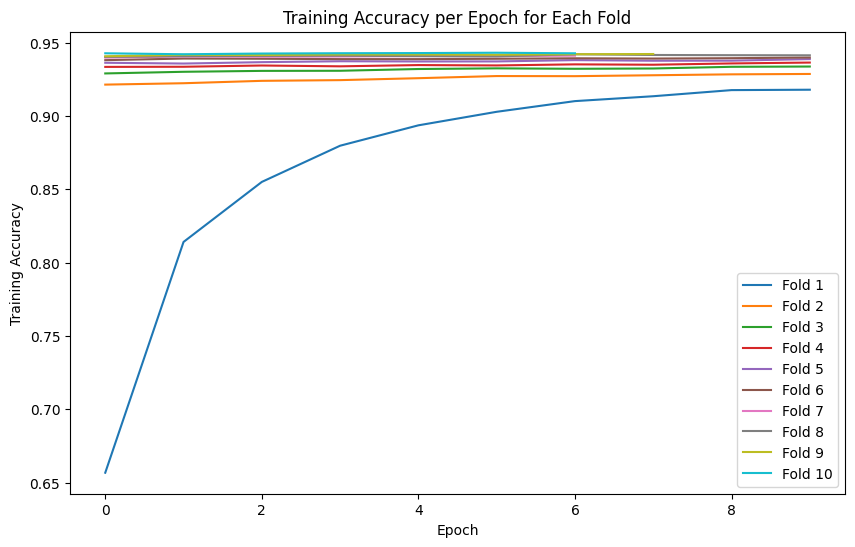

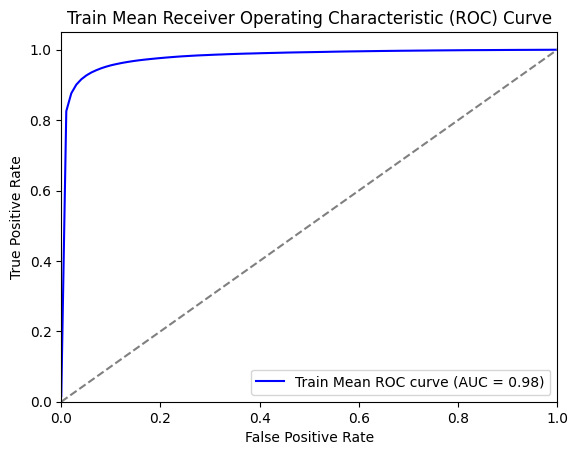

In [136]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_train_folds(fold_train_losses, 'Loss')
plot_train_folds(fold_train_accuracies, 'Accuracy')

train_mean_tpr = np.mean(train_tprs, axis=0)
train_mean_auc = auc(train_mean_fpr, train_mean_tpr)
plot_roc_auc_curve('Train', train_mean_tpr, train_mean_auc)

In [137]:
predict = np.round(model.predict(X_val_fold_tensor))

224/224 [==============================] - 0s 759us/step


In [138]:
accuracy = accuracy_score(y_val_fold_tensor, predict)
accuracy

0.9412669556705356

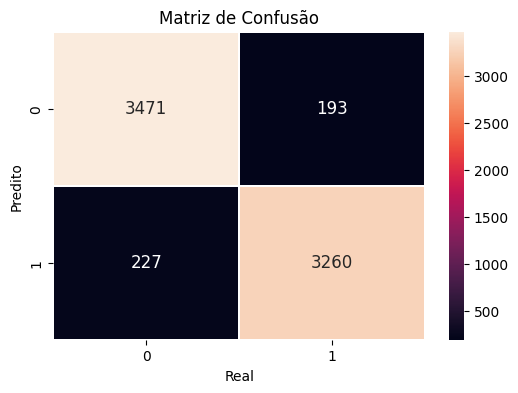

In [139]:
cm = confusion_matrix(y_val_fold_tensor, predict)
plot_confunsion_matrix(cm)